# Protein-Protein Interaction based on physical interaction

Summary:

1. Dataframe

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'personal_scripts')))
import graph
import pandas
import networkx
import math
import matplotlib.pyplot

Dependencies(graph.py): math, networkx, numpy


In [2]:
G_test = {"A": {("B", 1), ("D", 1), ("E",1)},
     "B": {("A", 1), ("C", 1), ("E",1)},
     "C": {("B", 1), ("G", 1), ("H",1)},
     "D": {("A", 1), ("E", 1)},
     "E": {("A", 1), ("B",1), ("D",1), ("F",1)},
     "F": {("E",1), ("G", 1)},
     "G": {("C",1), ("F", 1), ("H",1)},
     "H": {("C",1), ("G",1)}}

## Dataframe

In [2]:
transcriptome = pandas.read_csv("Data/saccharomyces_cerevisiae.tsv", sep="\t")
proteome = transcriptome.loc[transcriptome["GENE.type"] == "protein-coding"]
protein_properties = pandas.read_csv("Data/protein_properties.tsv", sep="\t").drop(columns=["Gene.proteins.secondaryIdentifier"])
abundance = pandas.read_csv("Data/abundance.tsv", sep="\t")

In [3]:
informations = proteome.merge(protein_properties,how="left", on="SYSTEMATIC.name").merge(abundance.drop(columns=["SYMBOL"]), on="SYSTEMATIC.name")
informations

,NCBI.accession,CHROMOSOME.begin,CHROMOSOME.end,CHROMOSOME.value,CHROMOSOME.orientation,GENE.name,SYMBOL,GENE.id,GENE.type,NCBI.transcripts_accession,...,PROTEINS.molecular_weight,PROTEINS.pI,PROTEINS.gravy_score,PROTEINS.aromaticity_score,PROTEINS.cai,PROTEINS.instability_index,PROTEINS.aliphatic_index,SGD.id,ABUNDANCE.value,ABUNDANCE.units
0,NC_001133.9,1807,2169,I,minus,seripauperin PAU8,PAU8,851229,protein-coding,NM_001180043.1,...,12846.7,4.96,0.25,0.09,0.63,19.78,90.09,S000002142,NaN,NaN
1,NC_001133.9,2480,2707,I,plus,uncharacterized protein,NaN,1466426,protein-coding,NM_001184582.1,...,8768.8,10.52,0.23,0.12,0.07,62.86,102.53,S000028593,NaN,NaN
2,NC_001133.9,7235,9016,I,minus,putative permease SEO1,SEO1,851230,protein-coding,NM_001178208.1,...,68845.6,8.15,-0.06,0.16,0.18,35.51,86.24,S000000062,1021.0,molecules/cell
3,NC_001133.9,11565,11951,I,minus,uncharacterized protein,NaN,851232,protein-coding,NM_001179897.1,...,12916.3,4.86,0.13,0.03,0.11,21.77,86.95,S000001817,NaN,molecules/cell
4,NC_001133.9,12046,12426,I,plus,uncharacterized protein,NaN,851233,protein-coding,NM_001180042.1,...,13256.3,3.92,0.97,0.03,0.07,28.09,123.47,S000002141,1219.0,molecules/cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6009,NC_001224.1,48901,50097,MT,plus,mitochondrial 37S ribosomal protein VAR1,VAR1,854586,protein-coding,NaN,...,47155.2,10.39,-0.79,0.09,0.09,41.68,81.18,S000007275,3940.0,molecules/cell
6010,NC_001224.1,61022,61729,MT,plus,intron-encoded endonuclease I-SceI,SCEI,854590,protein-coding,NaN,...,27693.6,9.71,-0.38,0.13,0.14,42.26,83.33,S000007279,NaN,NaN
6011,NC_001224.1,73758,74513,MT,plus,cytochrome c oxidase subunit 2,COX2,854622,protein-coding,NaN,...,28550.2,4.20,0.35,0.12,0.19,36.99,107.88,S000007281,4586.0,molecules/cell
6012,NC_001224.1,74495,75984,MT,plus,maturase-like protein,NaN,854623,protein-coding,NaN,...,56445.4,10.08,-0.51,0.14,0.12,41.08,81.51,S000007282,NaN,NaN


In [4]:
physical_interactions = pandas.read_csv("Data/physical_interactions.tsv", sep="\t")
physical_interactions = physical_interactions[physical_interactions["SYSTEMATIC.name_p1"].isin(informations["SYSTEMATIC.name"]) & physical_interactions["SYSTEMATIC.name_p2"].isin(informations["SYSTEMATIC.name"])]
physical_interactions

,SYSTEMATIC.name_p1,SYSTEMATIC.name_p2
76,YCL069W,YCR075C
77,YCL069W,YIL004C
78,YCL067C,YCR084C
79,YCL067C,YCR097W
80,YCL067C,YBR112C
...,...,...
82729,YPR159C-A,YDR479C
82730,YPR159C-A,YIR033W
82731,YPR159C-A,YIR038C
82732,YPR159C-A,YPL094C


In [27]:
phenotypes = pandas.read_csv("Data/phenotypes.tsv", sep="\t", keep_default_na=False)
phenotypes = phenotypes[phenotypes["SYSTEMATIC.name"].isin(informations["SYSTEMATIC.name"])]
phenotypes

,SGD.id,SYSTEMATIC.name,SYMBOL,MUTANT.type,PHENOTYPE.name,PHENOTYPE.qualifier
0,S000000001,YAL001C,TFC3,conditional,protein/peptide distribution,abnormal
1,S000000001,YAL001C,TFC3,conditional,protein/peptide distribution,abnormal
2,S000000001,YAL001C,TFC3,conditional,resistance to chemicals,decreased
3,S000000001,YAL001C,TFC3,conditional,resistance to chemicals,increased
4,S000000001,YAL001C,TFC3,conditional,resistance to chemicals,increased
...,...,...,...,...,...,...
194917,S000113613,YDR014W-A,HED1,null,protein/peptide accumulation,abnormal
194951,S000303806,YGR227C-A,OTO1,null,viable,
194952,S000303806,YGR227C-A,OTO1,overexpression,inviable,
194953,S000303806,YGR227C-A,OTO1,overexpression,vegetative growth,decreased rate


In [6]:
domains = pandas.read_csv("Data/domains.tsv", sep="\t")
domains = domains[domains["SYSTEMATIC.name"].isin(informations["SYSTEMATIC.name"])]
domains

,SYSTEMATIC.name,SYMBOL,DOMAIN.id,DOMAIN.name,DOMAIN.start,DOMAIN.end
0,YMR056C,AAC1,2136157,Mitochondrial carrier domain superfamily,14,309
1,YMR056C,AAC1,2138932,Mitochondrial substrate/solute carrier,10,106
2,YMR056C,AAC1,2138933,Mitochondrial substrate/solute carrier,116,210
3,YMR056C,AAC1,2138934,Mitochondrial substrate/solute carrier,217,304
4,YMR056C,AAC1,2138935,Mitochondrial carrier protein,16,29
...,...,...,...,...,...,...
48854,YPR204W,NaN,2161180,"Helicase, C-terminal",232,381
48855,YPR204W,NaN,2161181,"Helicase, C-terminal",257,337
48856,YPR204W,NaN,2174646,YML133C-like protein,1,174
48857,YPR204W,NaN,2174647,HELICASE WITH DEATH DOMAIN-RELATED,7,1030


In [7]:
structures = pandas.read_csv("Data/structures.tsv", sep="\t")
structures = structures[structures["SYSTEMATIC.name"].isin(informations["SYSTEMATIC.name"])]
structures

,SYSTEMATIC.name,STRUCTURE.type,STRUCTURE.begin,STRUCTURE.end
0,Q0045,HELIX,2,5
1,Q0045,HELIX,11,39
2,Q0045,STRAND,41,44
3,Q0045,STRAND,46,48
4,Q0045,HELIX,52,67
...,...,...,...,...
48003,YPR193C,HELIX,104,118
48004,YPR193C,STRAND,124,129
48005,YPR193C,HELIX,133,142
48006,YPR193C,STRAND,143,145


In [8]:
pathways = pandas.read_csv("Data/pathways.tsv", sep="\t")
pathways = pathways[pathways["SYSTEMATIC.name"].isin(informations["SYSTEMATIC.name"])]
pathways

,PATHWAY.name,SYSTEMATIC.name
0,2-Oxocarboxylic acid metabolis,YLL039C
1,2-Oxocarboxylic acid metabolis,YIL148W
2,2-Oxocarboxylic acid metabolis,YKR094C
3,2-Oxocarboxylic acid metabolis,YLR167W
4,2-Oxocarboxylic acid metabolis,YKL210W
...,...,...
4089,Vitamin B6 metabolism,YFL059W
4090,Vitamin B6 metabolism,YNL333W
4091,Vitamin B6 metabolism,YMR095C
4092,Vitamin B6 metabolism,YFL060C


In [9]:
gene_ontology = pandas.read_csv("Data/gene_ontology.tsv", sep="\t")
gene_ontology = gene_ontology[gene_ontology["SYSTEMATIC.name"].isin(informations["SYSTEMATIC.name"])]
gene_ontology

,SYSTEMATIC.name,GO.id,GO.term
0,Q0045,GO:0031966,C:mitochondrial membrane
1,Q0045,GO:0005751,C:mitochondrial respiratory chain complex IV
2,Q0045,GO:0005739,C:mitochondrion
3,Q0045,GO:0004129,F:cytochrome-c oxidase activity
4,Q0045,GO:0020037,F:heme binding
...,...,...,...
48946,YPR204W,GO:0005524,F:ATP binding
48947,YPR204W,GO:0016887,F:ATP hydrolysis activity
48948,YPR204W,GO:0003678,F:DNA helicase activity
48949,YPR204W,GO:0003676,F:nucleic acid binding


In [10]:
sequences = pandas.read_csv("Data/sequences.tsv", sep="\t")
sequences = sequences[sequences["SYSTEMATIC.name"].isin(informations["SYSTEMATIC.name"])]
sequences

,SYSTEMATIC.name,PROTEIN.seq
0,Q0045,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...
1,Q0050,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...
2,Q0055,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...
3,Q0060,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...
4,Q0065,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...
...,...,...
6009,YPR200C,MVSFITSRQLKGLIENQRKDFQVVDLRREDFARDHITNAWHVPVTA...
6010,YPR201W,MSEDQKSENSVPSKVNMVNRTDILTTIKSLSWLDLMLPFTIILSII...
6011,YPR202W,MEIENEQICTCIAQILHLLNSLIITFSDDDKTETGQSFVYIDGFLV...
6012,YPR203W,MRTFTDFVSGAPIVRSLQKSTIRKYGYNLAPHMFLLLHVDELSIFS...


## Graph based method

<img src="Image/physical_interactome.png" />

In [11]:
G = dict()
V = set(informations["SYSTEMATIC.name"])
E = {(inter["SYSTEMATIC.name_p1"], inter["SYSTEMATIC.name_p2"]) for _, inter in physical_interactions.iterrows()}.union({(inter["SYSTEMATIC.name_p2"], inter["SYSTEMATIC.name_p1"]) for _, inter in physical_interactions.iterrows()})

In [13]:
print(f"Vertices: {len(V)}\nEdges: {int(len(E)/2)}")

Vertices: 6014
Edges: 81941


In [12]:
G = {vertice: set() for vertice in V}
for edge in E:  G[edge[0]].add((edge[1], 1))
print(f"YAL068C: {G["YAL068C"]}")

YAL068C: {('YBL032W', 1), ('YGL158W', 1), ('YMR080C', 1)}


### Properties

In [13]:
#isolated
print("Connected components before deleting isolated vertices:", len(graph.connected_component(G)))
isolated = graph.isolated_vertex(G)
print("Vertices isolated:", len(isolated))
for vertex in isolated:
    G = graph.delete_vertex(G, vertex)
print("Connected components after deleting isolated vertices:", len(graph.connected_component(G)))

Connected components before deleting isolated vertices: 314
Vertices isolated: 313
Connected components after deleting isolated vertices: 1


In [17]:
#Articulation
articulation = set()
for vertex in G:
    if list(graph.deep_first_search(G, vertex).values()).count(vertex) > 1:
        articulation.add(vertex)
len(articulation)

80

In [18]:
#Center and Diameter
center = set()
for vertex in G:
    center.add((vertex, graph.eccentricity(G, vertex)))
dist_diameter = max(list(map(lambda x: x[1], center)))
diameter = {v[0] for v in center if v[1] == dist_diameter}
dist_center = min(list(map(lambda x: x[1], center)))
center = {v[0] for v in center if v[1] == dist_center}

print(f"Diameter of {dist_diameter}:", diameter)
print(f"Center of {dist_center}:", center)

Diameter of 6: {'YFL055W', 'YIR028W', 'YDR144C', 'YPL280W', 'YPR186C', 'YOR067C', 'YMR030W', 'YGL183C'}
Center of 3: {'YFR004W', 'YPL240C', 'YGL122C'}


In [17]:
#Characteristic path length
c_p_t = 0
W, L = graph.distance_matrix(G)
W, S = graph.Floyd_Warshall(W, L)
for vertex in G:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0
    c_p_t += avg

print(f"Characteristic path length: {c_p_t/(len(G)*(len(G)-1))}")

Characteristic path length: 2.486852229679619


In [20]:
#Global efficiency
for vertex in G:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0

avg = 1/avg

print(f"Global efficiency: {(1/(len(G)*(len(G)-1)))*avg}")

Global efficiency: 0.42231191931469236


In [23]:
#Clustering coefficient
avg = 0
m = max(set().union(*(s for s in G.values())), key=lambda edge: edge[1])[1]
for vertex in G:
    avg += graph.clustering_value(W, L, G, vertex, m)

print(f"Clustering coefficient: {avg/len(G)}")


Clustering coefficient: 0.25744971160872937


In [24]:
#Degree centrality
degree = {vertex: 0 for vertex in G}
for vertex in G:
    degree[vertex] = len(G[vertex])/len(G)

print(f"Degree centrality: YFL055W => {degree["YFL055W"]}, YFR004W => {degree["YFR004W"]}")

Degree centrality: YFL055W => 0.00017540782318891423, YFR004W => 0.13822136467286442


In [27]:
#Closeness centrality
closeness = {vertex: 0 for vertex in G}
for vertex in G:
    clsnss = 0
    for i in range(len(G)):
        if i != L[vertex]:
            clsnss += W[L[vertex], i]
    closeness[vertex] = 1/clsnss

print(f"Closeness centrality: YFL055W => {closeness["YFL055W"]}, YFR004W => {closeness["YFR004W"]}")

Closeness centrality: YFL055W => 0.247234873129473, YFR004W => 0.5232718259432663


### Communities

In [19]:
#Gamma = 0.5
Cg05 = graph.Louvain_undirected(G, 0.5)

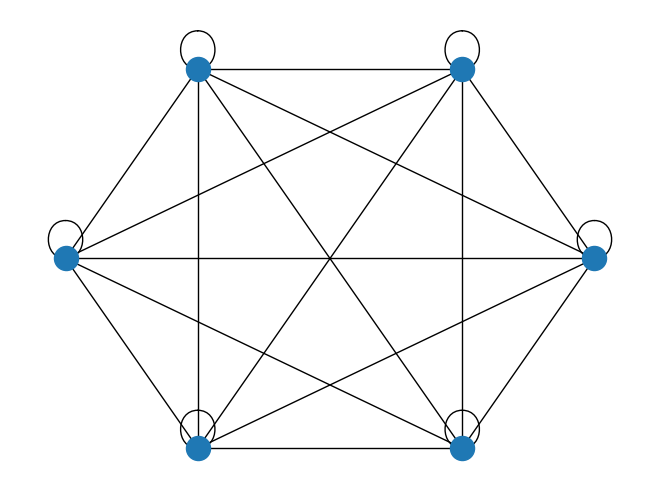

In [25]:
networkx.draw_circular(graph.dict_to_networkx(Cg05))
#gephi

In [26]:
print(f"Communities: {len(Cg05)}")


#Articulation
articulation = set()
for vertex in Cg05:
    if list(graph.deep_first_search(Cg05, vertex).values()).count(vertex) > 1:
        articulation.add(vertex)
print(f"Articulations: {len(articulation)}")


#Center and Diameter
center = set()
for vertex in Cg05:
    center.add((vertex, graph.eccentricity(Cg05, vertex)))
dist_diameter = max(list(map(lambda x: x[1], center)))
diameter = {v[0] for v in center if v[1] == dist_diameter}
dist_center = min(list(map(lambda x: x[1], center)))
center = {v[0] for v in center if v[1] == dist_center}

print(f"Diameter of {dist_diameter}:", diameter)
print(f"Center of {dist_center}:", center)


#Characteristic path length
c_p_t = 0
W, L = graph.distance_matrix(Cg05)
W, S = graph.Floyd_Warshall(W, L)
for vertex in Cg05:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0
    c_p_t += avg

print(f"Characteristic path length: {c_p_t/(len(Cg05)*(len(Cg05)-1))}")


#Global efficiency
for vertex in Cg05:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0

avg = 1/avg

print(f"Global efficiency: {(1/(len(Cg05)*(len(Cg05)-1)))*avg}")


#Clustering coefficient
avg = 0
m = max(set().union(*(s for s in Cg05.values())), key=lambda edge: edge[1])[1]
for vertex in Cg05:
    avg += graph.clustering_value(W, L, Cg05, vertex, m)

print(f"Clustering coefficient: {avg/len(Cg05)}")


Communities: 6
Articulations: 0
Diameter of 1:
Center of 1:
Characteristic path length: 1.0
Global efficiency: 1.0
Clustering coefficient: 1.0


In [21]:
#Gamma = 1
Cg1 = graph.Louvain_undirected(G, 1)

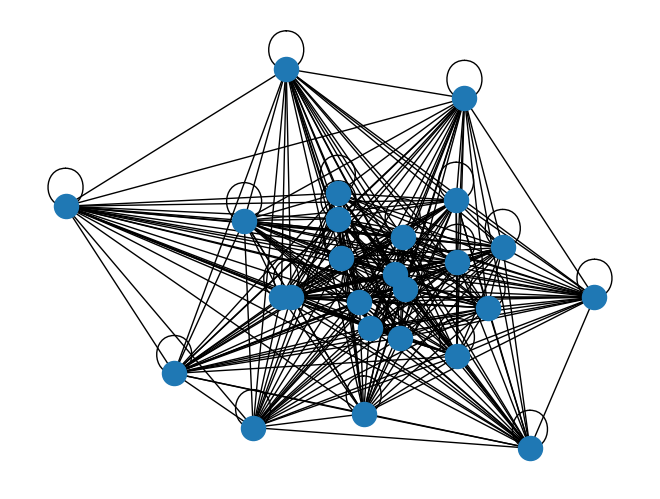

In [18]:
networkx.draw(graph.dict_to_networkx(Cg1))

In [27]:
print(f"Communities: {len(Cg1)}")


#Articulation
articulation = set()
for vertex in Cg1:
    if list(graph.deep_first_search(Cg1, vertex).values()).count(vertex) > 1:
        articulation.add(vertex)
print(f"Articulations: {len(articulation)}")


#Center and Diameter
center = set()
for vertex in Cg1:
    center.add((vertex, graph.eccentricity(Cg1, vertex)))
dist_diameter = max(list(map(lambda x: x[1], center)))
diameter = {v[0] for v in center if v[1] == dist_diameter}
dist_center = min(list(map(lambda x: x[1], center)))
center = {v[0] for v in center if v[1] == dist_center}

print(f"Diameter of {dist_diameter}:", diameter)
print(f"Center of {dist_center}:", center)


#Characteristic path length
c_p_t = 0
W, L = graph.distance_matrix(Cg1)
W, S = graph.Floyd_Warshall(W, L)
for vertex in Cg1:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0
    c_p_t += avg

print(f"Characteristic path length: {c_p_t/(len(Cg1)*(len(Cg1)-1))}")


#Global efficiency
for vertex in Cg1:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0

avg = 1/avg

print(f"Global efficiency: {(1/(len(Cg1)*(len(Cg1)-1)))*avg}")


#Clustering coefficient
avg = 0
m = max(set().union(*(s for s in Cg1.values())), key=lambda edge: edge[1])[1]
for vertex in Cg1:
    avg += graph.clustering_value(W, L, Cg1, vertex, m)

print(f"Clustering coefficient: {avg/len(Cg1)}")


Communities: 21
Articulations: 0
Diameter of 1:
Center of 1:
Characteristic path length: 1.0
Global efficiency: 1.0
Clustering coefficient: 1.0


In [14]:
#Gamma = 1.5
Cg15 = graph.Louvain_undirected(G, 1.5)

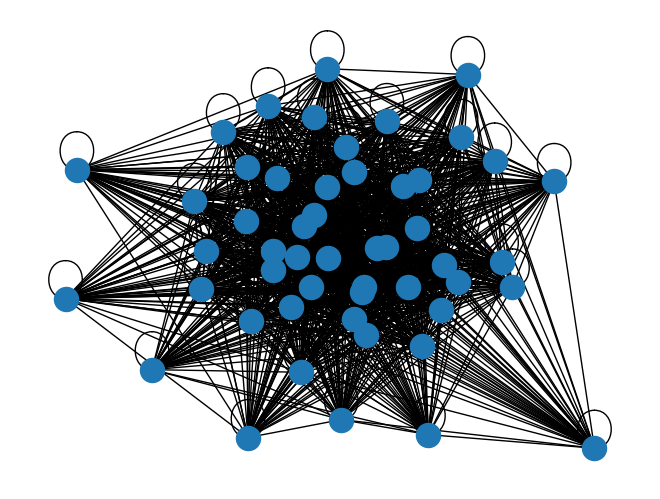

In [16]:
networkx.draw(graph.dict_to_networkx(Cg15))

In [28]:
print(f"Communities: {len(Cg15)}")


#Articulation
articulation = set()
for vertex in Cg15:
    if list(graph.deep_first_search(Cg15, vertex).values()).count(vertex) > 1:
        articulation.add(vertex)
print(f"Articulations: {len(articulation)}")


#Center and Diameter
center = set()
for vertex in Cg15:
    center.add((vertex, graph.eccentricity(Cg15, vertex)))
dist_diameter = max(list(map(lambda x: x[1], center)))
diameter = {v[0] for v in center if v[1] == dist_diameter}
dist_center = min(list(map(lambda x: x[1], center)))
center = {v[0] for v in center if v[1] == dist_center}

print(f"Diameter of {dist_diameter}:", diameter)
print(f"Center of {dist_center}:", center)


#Characteristic path length
c_p_t = 0
W, L = graph.distance_matrix(Cg15)
W, S = graph.Floyd_Warshall(W, L)
for vertex in Cg15:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0
    c_p_t += avg

print(f"Characteristic path length: {c_p_t/(len(Cg15)*(len(Cg15)-1))}")


#Global efficiency
for vertex in Cg15:
    avg = 0
    for i in range(len(W)):
        avg += W[L[vertex], i] if L[vertex] != i else 0

avg = 1/avg

print(f"Global efficiency: {(1/(len(Cg15)*(len(Cg15)-1)))*avg}")


#Clustering coefficient
avg = 0
m = max(set().union(*(s for s in Cg15.values())), key=lambda edge: edge[1])[1]
for vertex in Cg15:
    avg += graph.clustering_value(W, L, Cg15, vertex, m)

print(f"Clustering coefficient: {avg/len(Cg15)}")


Communities: 51
Articulations: 0
Diameter of 2:
Center of 1:
Characteristic path length: 1.0172549019607844
Global efficiency: 0.9913725490196078
Clustering coefficient: 0.9851450850109572


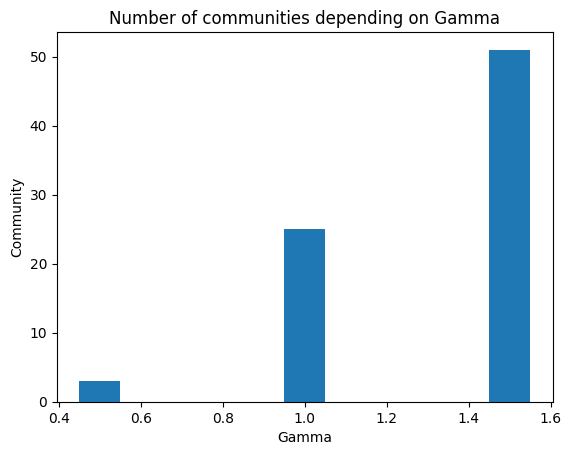

In [54]:
#Comparative Vertices
matplotlib.pyplot.bar(x=[0.5, 1, 1.5], height=[len(Cg05), len(Cg1), len(Cg15)], width=0.1)
matplotlib.pyplot.title("Number of communities depending on Gamma")
matplotlib.pyplot.xlabel("Gamma")
matplotlib.pyplot.ylabel("Community")
matplotlib.pyplot.show()

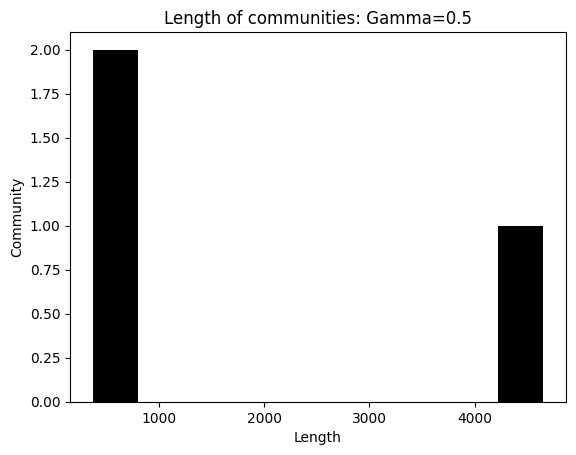

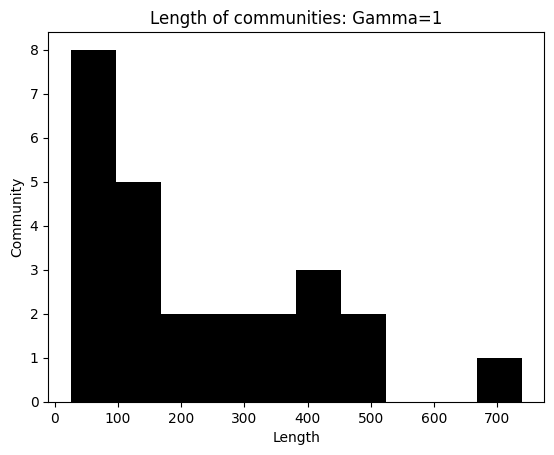

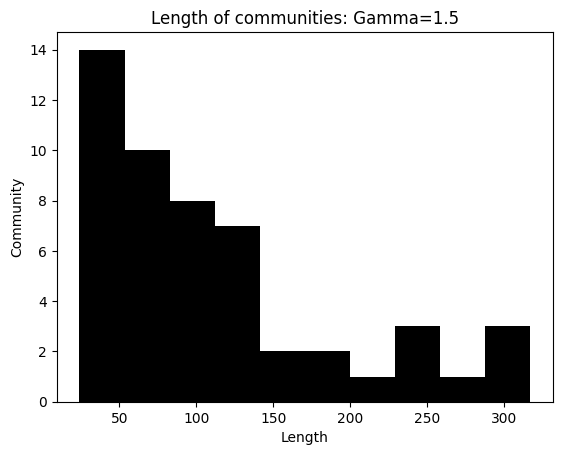

In [64]:
#Comparative length of communities
for C in [("Gamma=0.5", Cg05), ("Gamma=1", Cg1), ("Gamma=1.5", Cg15)]:
    matplotlib.pyplot.hist(x=[len(community.split('/')) for community in C[1]], label="Gamma=0.5", color="black")
    matplotlib.pyplot.title(f"Length of communities: {C[0]}")
    matplotlib.pyplot.xlabel("Length")
    matplotlib.pyplot.ylabel("Community")
    matplotlib.pyplot.show()

In [15]:
#Sequence and Structure Analysis
Cg2 = graph.Louvain_undirected(G, 2)

In [16]:
len(Cg2)

73

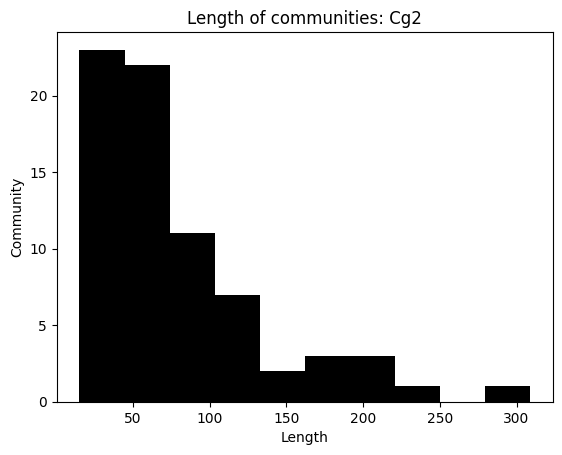

In [17]:
matplotlib.pyplot.hist(x=[len(community.split('/')) for community in Cg2], label="Gamma=0.5", color="black")
matplotlib.pyplot.title(f"Length of communities: Cg2")
matplotlib.pyplot.xlabel("Length")
matplotlib.pyplot.ylabel("Community")
matplotlib.pyplot.show()

### Community analysis based on Gamma = 2

<img src="Image/community_10.png"/>

motif enrichment

<img src="Chart/Viable/community_10.png"/>